<a href="https://colab.research.google.com/github/cxbxmxcx/PracticalRL/blob/master/PRL_Taxi_MAXQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [0]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Agent definition

In [0]:
class Agent:
    def __init__(self, env, alpha, gamma):
        self.env = env
        
        not_pr_acts = 2 + 1 + 1 + 1   # gotoS,D + put + get + root (non primitive actions)
        nA = env.action_space.n + not_pr_acts       
        nS = env.observation_space.n
        self.V = np.ones((nA, nS))
        self.C = np.ones((nA, nS, nA))
        self.V_copy = self.V.copy()
        
        s = self.south = 0
        n = self.north = 1
        e = self.east = 2
        w = self.west = 3
        pickup = self.pickup = 4
        dropoff = self.dropoff = 5
        gotoS = self.gotoS = 6
        gotoD = self.gotoD = 7
        get = self.get = 8
        put = self.put = 9
        root = self.root = 10
        
        self.graph = [
            set(),  # south
            set(),  # north
            set(),  # east
            set(),  # west
            set(),  # pickup
            set(),  # dropoff
            {s, n, e, w},  # gotoSource
            {s, n, e, w},  # gotoDestination
            {pickup, gotoS},  # get -> pickup, gotoSource
            {dropoff, gotoD},  # put -> dropoff, gotoDestination
            {put, get},  # root -> put, get
        ]
        
        self.alpha = alpha
        self.gamma = gamma
        self.r_sum = 0
        self.new_s = copy.copy(self.env.s)
        self.done = False
        self.num_of_ac = 0

    def is_primitive(self, act):
        if act <= 5:
            return True
        else:
            return False
    
    def is_terminal(self, a, done):
        RGBY = [(0, 0), (0, 4), (4, 0), (4, 3)]
        taxirow, taxicol, passidx, destidx = list(self.env.decode(self.env.s))
        taxiloc = (taxirow, taxicol)
        if done:
            return True
        elif a == self.root:
            return done
        elif a == self.put:
            return passidx < 4
        elif a == self.get:
            return passidx >= 4
        elif a == self.gotoD:
            return passidx >= 4 and taxiloc == RGBY[destidx]
        elif a == self.gotoS:
            return passidx < 4 and taxiloc == RGBY[passidx]
        elif self.is_primitive(a):
            # just else
            return True

        
    def evaluate(self, act, s):
            if self.is_primitive(act):
                return self.V_copy[act, s]
            else:
                for j in self.graph[act]:
                    self.V_copy[j, s] = self.evaluate(j, s)
                Q = np.arange(0)
                for a2 in self.graph[act]:
                    Q = np.concatenate((Q, [self.V_copy[a2, s]]))
                max_arg = np.argmax(Q)
                return self.V_copy[max_arg, s]
            
    # e-Greedy Approach with eps=0.001
    def greed_act(self, act, s):
        e = 0.001
        Q = np.arange(0)
        possible_a = np.arange(0)
        for act2 in self.graph[act]:
            if self.is_primitive(act2) or (not self.is_terminal(act2, self.done)):
                Q = np.concatenate((Q, [self.V[act2, s] + self.C[act, s, act2]]))
                possible_a = np.concatenate((possible_a, [act2]))
        max_arg = np.argmax(Q)
        if np.random.rand(1) < e:
            return np.random.choice(possible_a)
        else:
            return possible_a[max_arg]
        
        
    def MAXQ_0(self, i, s):  # i is action number
        if self.done:
            i = 11                  # to end recursion
        self.done = False
        if self.is_primitive(i):
            self.new_s, r, self.done, _ = copy.copy(self.env.step(i))
            self.r_sum += r
            self.num_of_ac += 1
            self.V[i, s] += self.alpha * (r - self.V[i, s])
            return 1
        elif i <= self.root:
            count = 0
            while not self.is_terminal(i, self.done): # a is new action num
                a = self.greed_act(i, s)
                N = self.MAXQ_0(a, s)
                self.V_copy = self.V.copy()
                evaluate_res = self.evaluate(i, self.new_s)
                self.C[i, s, a] += self.alpha * (self.gamma ** N * evaluate_res - self.C[i, s, a])
                count += N
                s = self.new_s
            return count
        
    def reset(self):
        self.env.reset()
        self.r_sum = 0
        self.num_of_ac = 0
        self.done = False
        self.new_s = copy.copy(self.env.s)


Training Code

already made 0 episodes
already made 1000 episodes
already made 2000 episodes
already made 3000 episodes
already made 4000 episodes
already made 5000 episodes



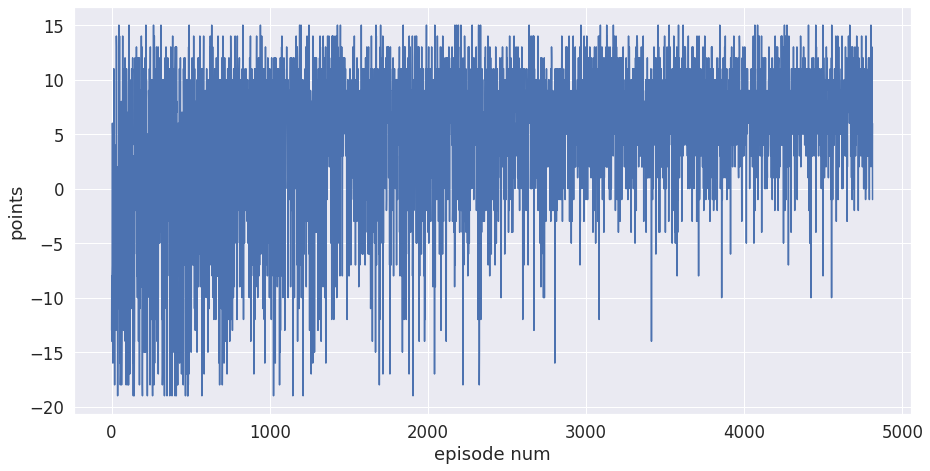

In [0]:
alpha = 0.15
gamma = .7
env = gym.make('Taxi-v3').env
taxi = Agent(env, alpha, gamma)
episodes = 5501
sum_list = []
for j in tqdm(range(episodes)):
    taxi.reset()
    taxi.MAXQ_0(10, env.s)      # start in root
    if taxi.r_sum > -20:
      sum_list.append(taxi.r_sum)
    if (j % 1000 == 0):
        print('already made', j, 'episodes')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 7.5))
plt.plot(sum_list)
plt.xlabel('episode num')
plt.ylabel('points')
plt.show()